In [1]:
import os 
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import hashlib
from scipy.stats import uniform, expon, reciprocal
from pandas.plotting import scatter_matrix

from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, 
                                     cross_val_score, GridSearchCV, RandomizedSearchCV)
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
# Script for getting csv data
#
# DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
# HOUSING_PATH = "datasets/housing"
# HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
# def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
#     if not os.path.isdir(housing_path):
#         os.makedirs(housing_path)
#         tgz_path = os.path.join(housing_path, "housing.tgz")
#         urllib.request.urlretrieve(housing_url, tgz_path)
#         housing_tgz = tarfile.open(tgz_path)
#         housing_tgz.extractall(path=housing_path)
#         housing_tgz.close()
# fetch_housing_data()

In [3]:
housing = pd.read_csv(".\Datasets\housing\housing.csv")

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.ocean_proximity.value_counts() #by default shown in descending order

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


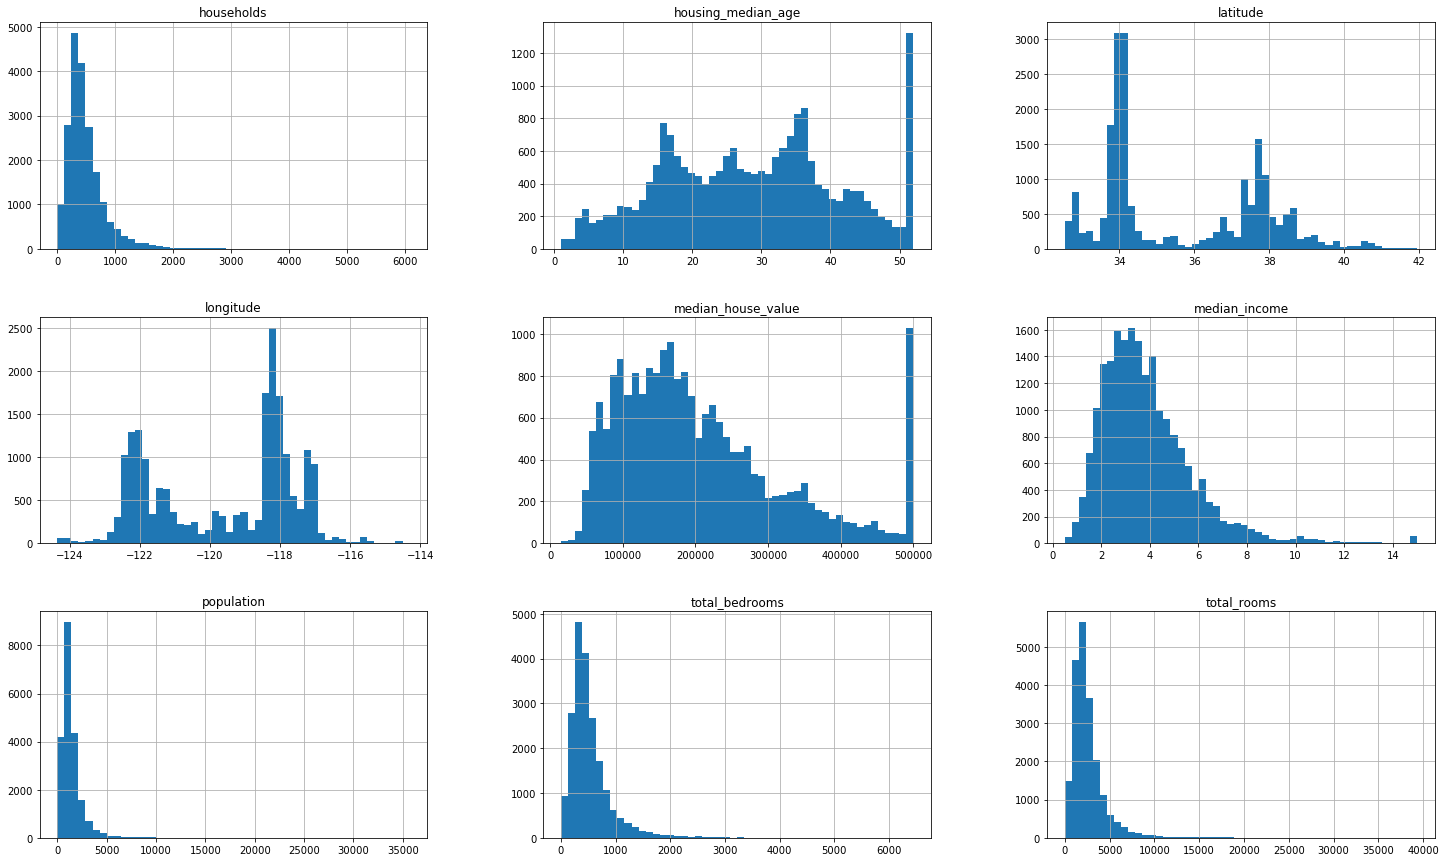

In [8]:
housing.hist(bins=50, figsize=(25, 15))
plt.show()

## Different ways of splitting data into training and test sets

### 1.

In [9]:
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(test_ratio*len(data))
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(train_set.shape, test_set.shape)

(16512, 10) (4128, 10)


In [11]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [12]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### 2.

In [13]:
housing_with_id = housing.reset_index()
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(train_set.shape, test_set.shape)

(16362, 11) (4278, 11)


In [16]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [17]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


### 3.

In [18]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
print(train_set.shape, test_set.shape)

(16512, 10) (4128, 10)


In [19]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [20]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### 4.

In [21]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)

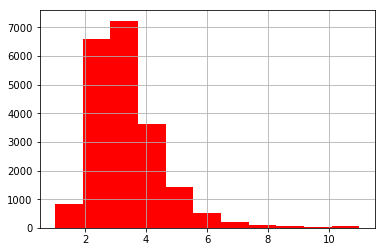

In [22]:
housing.income_cat.hist(bins = len(set(housing.income_cat)), color = "red")

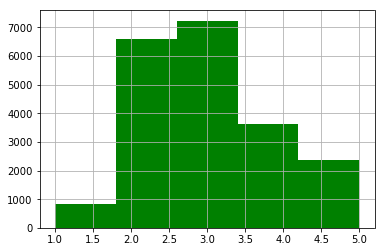

In [23]:
housing.income_cat.where(housing.income_cat < 5, 5.0, inplace = True)
housing.income_cat.hist(bins = len(set(housing.income_cat)), color = "green")

In [24]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [25]:
print(housing.income_cat.value_counts()/len(housing))
print(strat_train_set.income_cat.value_counts()/len(strat_train_set))
print(strat_test_set.income_cat.value_counts()/len(strat_test_set))


3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [26]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis = 1, inplace = True)

## Visualizing the data

In [27]:
housing = strat_train_set.copy()

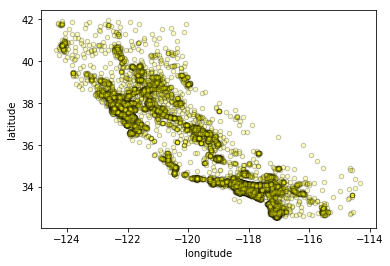

In [28]:
housing.plot(kind = "scatter", x="longitude", y="latitude", edgecolors="black", c = "yellow", alpha = "0.25")

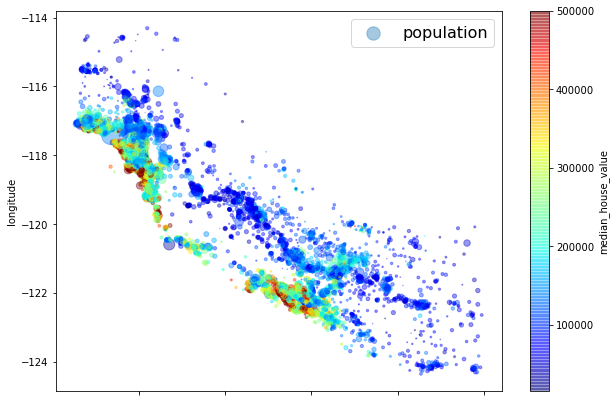

In [29]:
ax1 = housing.plot(kind = "scatter", x = "latitude", y = "longitude",
            alpha = 0.4, s = housing["population"]/100, label = "population",
            c = "median_house_value", cmap=plt.get_cmap("jet"), colorbar = True, figsize = (10, 7))
plt.legend(fontsize = 16)

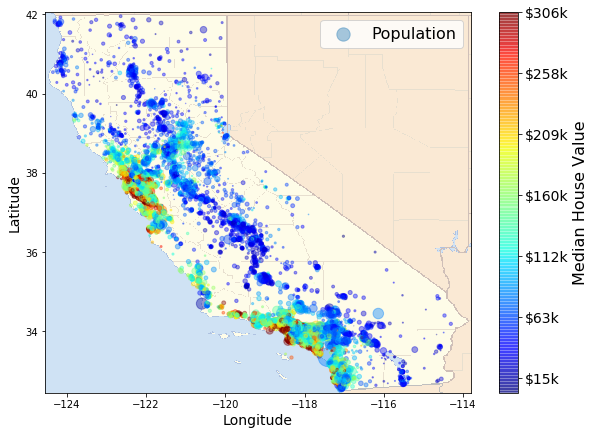

In [30]:
california_img=mpimg.imread('.\Images\Housing\california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [31]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [32]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

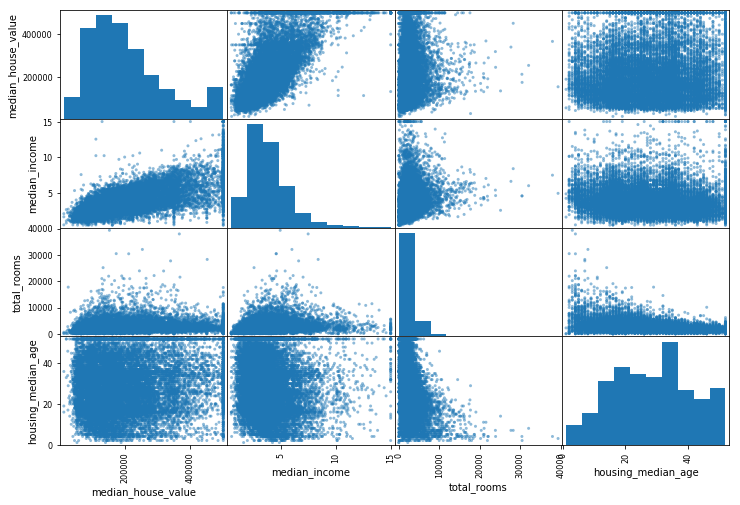

In [33]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12, 8))
plt.show()

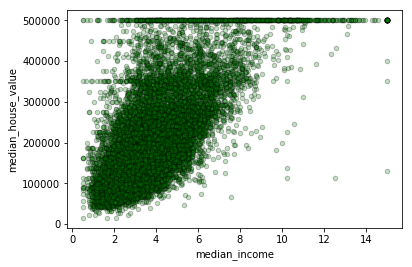

In [34]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", c = "green", edgecolors = "black", alpha = "0.25")

## Experimenting with attributes

In [35]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

### Custom Transformer to add above attributes:

In [36]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [37]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Preparing data for ML algorithms

In [38]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [39]:
imputer = SimpleImputer(strategy = "median")
housing_num  = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
X = imputer.transform(housing_num)

In [41]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

In [42]:
housing_cat  = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [43]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [44]:
print(ordinal_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [45]:
encoder = OneHotEncoder(categories = 'auto', sparse = False)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

## Pipeline for above transformations and standardization

In [46]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]


num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(categories = 'auto', sparse = False), cat_attribs),
    ])

In [47]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [48]:
housing_prepared.shape

(16512, 16)

In [49]:
pd.DataFrame(housing_prepared).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0
5,-0.696456,0.945009,-0.370047,0.143693,0.131447,0.025285,0.194138,-0.176435,-0.114867,-0.048003,-0.199264,0.0,1.0,0.0,0.0,0.0
6,0.537433,-0.748168,1.856709,-0.182253,-0.528198,-0.583328,-0.585720,2.366702,1.003599,-0.027646,-1.097923,1.0,0.0,0.0,0.0,0.0
7,1.166867,-0.696718,-0.210993,-0.272040,-0.586617,-0.433639,-0.324880,1.115239,0.000891,-0.051831,-1.073504,0.0,1.0,0.0,0.0,0.0
8,0.657325,-0.771554,1.459074,-0.354345,-0.167949,0.444770,-0.157197,-1.076906,-0.452724,0.110319,0.545225,1.0,0.0,0.0,0.0,0.0
9,0.647334,-0.757522,0.027588,-0.985660,-0.742400,1.138535,-0.745417,-1.772116,-1.174387,0.802788,3.534531,1.0,0.0,0.0,0.0,0.0


## Training and evaluation on training set

### Linear Regressor

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [53]:
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", some_labels.values)

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600. 340600. 196900.  46300. 254500.]


In [54]:
predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
print("Root mean squared error: ", lin_rmse)

Root mean squared error:  68628.19819848923


### Decision Tree Regressor

In [55]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, predictions)
tree_rmse = np.sqrt(tree_mse)
print("Root mean squared error: ", tree_rmse)

Root mean squared error:  0.0


In [56]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                        scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [57]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())
    
print("Linear regressor: ")
display_scores(lin_rmse_scores)

print("\nDecision tree regressor: ")
display_scores(tree_rmse_scores)

Linear regressor: 
Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.6740017983493

Decision tree regressor: 
Scores:  [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean:  70666.74616904806
Standard deviation:  2928.322738055112


### Random Forest Regressor

In [58]:
forest_reg  = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
print("Root mean squared error: ", forest_rmse)

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Root mean squared error:  22256.354579885898


In [59]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                        scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [52868.21871547 49194.92340594 51713.77716246 55012.10310441
 50973.88861214 55990.4479905  52298.68285092 50953.09058463
 54428.48087563 53461.73225682]
Mean:  52689.53455589254
Standard deviation:  1980.36257012708


## Fine-tune the model

### Grid search

In [60]:
param_grid = [
{'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 6, 8, 10]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 6, 8, 10]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [61]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [62]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 50}

In [63]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64560.56453532923 {'max_features': 2, 'n_estimators': 3}
55582.7022830937 {'max_features': 2, 'n_estimators': 10}
52946.41821544518 {'max_features': 2, 'n_estimators': 30}
52191.386641170146 {'max_features': 2, 'n_estimators': 50}
59903.69485491165 {'max_features': 4, 'n_estimators': 3}
52774.9038937849 {'max_features': 4, 'n_estimators': 10}
50358.56603093497 {'max_features': 4, 'n_estimators': 30}
50157.309125727654 {'max_features': 4, 'n_estimators': 50}
59003.949002832735 {'max_features': 6, 'n_estimators': 3}
52306.02228399712 {'max_features': 6, 'n_estimators': 10}
49957.812184794304 {'max_features': 6, 'n_estimators': 30}
49486.52315883182 {'max_features': 6, 'n_estimators': 50}
59251.797171880506 {'max_features': 8, 'n_estimators': 3}
52340.7150836036 {'max_features': 8, 'n_estimators': 10}
50081.89071348217 {'max_features': 8, 'n_estimators': 30}
49780.88468516142 {'max_features': 8, 'n_estimators': 50}
58696.61927070334 {'max_features': 10, 'n_estimators': 3}
52542.7572463211

In [64]:
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

[7.97604643e-02 7.46467612e-02 4.15513492e-02 1.76030880e-02
 1.64543492e-02 1.73360075e-02 1.58177666e-02 3.26764343e-01
 6.07705222e-02 1.05819152e-01 7.75786011e-02 1.45621645e-02
 1.41946447e-01 6.82976356e-05 4.03133169e-03 5.28935574e-03]


In [65]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_attribs = [ordinal_encoder.categories_[0][i] for i in range(len(ordinal_encoder.categories_[0]))]
attribs = num_attribs + extra_attribs + cat_attribs
attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [66]:
sorted(zip(feature_importances, attribs), reverse=True)

[(0.32676434255096803, 'median_income'),
 (0.14194644672305384, 'INLAND'),
 (0.10581915183112521, 'pop_per_hhold'),
 (0.07976046433427796, 'longitude'),
 (0.07757860114626611, 'bedrooms_per_room'),
 (0.07464676124975715, 'latitude'),
 (0.060770522235886165, 'rooms_per_hhold'),
 (0.04155134916724255, 'housing_median_age'),
 (0.017603088027007427, 'total_rooms'),
 (0.01733600748173287, 'population'),
 (0.016454349178334424, 'total_bedrooms'),
 (0.015817766555113508, 'households'),
 (0.014562164453096627, '<1H OCEAN'),
 (0.005289355743005675, 'NEAR OCEAN'),
 (0.004031331687568767, 'NEAR BAY'),
 (6.82976355637497e-05, 'ISLAND')]

## Evaluating on test set

In [ ]:
final_model = grid_search.best_estimator_

In [49]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [50]:
X_test_prepared.shape

(4128, 16)

In [69]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [70]:
print(final_rmse)

46939.188731864575


## Trying Support Vector Regressor along with RandomizedSearchCV

In [ ]:
param_dist = {'kernel': ['linear', 'rbf', 'poly'],'C': reciprocal(20, 20000),
        'gamma': expon(scale=1.0)}
svr = SVR()
randomized_search = RandomizedSearchCV(svr, param_dist, cv=5, n_iter=1, 
                                       scoring='neg_mean_squared_error', verbose = 2, random_state=42)
randomized_search.fit(housing_prepared, housing_labels)


In [ ]:
randomized_search.best_estimator_

In [ ]:
svm_model = randomized_search.best_estimator_
svm_predictions = svm_model.predict(X_test_prepared)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_rmse = np.sqrt(svm_mse)

In [88]:
svm_rmse

93872.80380189487